In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss, roc_auc_score, RocCurveDisplay, roc_curve
import numpy as np
import pandas as pd
from IMPJ import DataProcessor
import random
import matplotlib.pyplot as plt
from os.path import basename, exists
import matplotlib as mpl
import random
from tqdm import tqdm

randomstate = random.randint(1,1000) 

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download('https://github.com/AllenDowney/AstronomicalData/raw/main/' + 'az-paper-twocol.mplstyle')
plt.style.use('./az-paper-twocol.mplstyle')

In [6]:
dp = DataProcessor()

In [7]:
'''
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
hl_list = []
for i in range(1,100):
        for k in range(1,100):
               
                hl_list.append((i,k))
        
model_parameters = {
        'hidden_layer_sizes':hl_list,
        'activation':['tanh','relu'],
        'solver':['lbfgs','sgd','adam'],
        'learning_rate':['constant','invscaling','adaptive']
}
NN = MLPClassifier(random_state=1)
clf = RandomizedSearchCV(NN, model_parameters, n_jobs=-1, cv=20,scoring='roc_auc')
clf.fit(x_train, y_train)
#NN = MLPClassifier(activation='relu', alpha= 0.0001, hidden_layer_sizes=(30,20,10), learning_rate='constant', solver='sgd', random_state=1, max_iter=10000)

# All results
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print('Best parameters found:\n', clf.best_params_ )
print('Best Score (ROC-AUC) was: \n', clf.best_score_)'''


'\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom skopt import BayesSearchCV\nhl_list = []\nfor i in range(1,100):\n        for k in range(1,100):\n               \n                hl_list.append((i,k))\n        \nmodel_parameters = {\n        \'hidden_layer_sizes\':hl_list,\n        \'activation\':[\'tanh\',\'relu\'],\n        \'solver\':[\'lbfgs\',\'sgd\',\'adam\'],\n        \'learning_rate\':[\'constant\',\'invscaling\',\'adaptive\']\n}\nNN = MLPClassifier(random_state=1)\nclf = RandomizedSearchCV(NN, model_parameters, n_jobs=-1, cv=20,scoring=\'roc_auc\')\nclf.fit(x_train, y_train)\n#NN = MLPClassifier(activation=\'relu\', alpha= 0.0001, hidden_layer_sizes=(30,20,10), learning_rate=\'constant\', solver=\'sgd\', random_state=1, max_iter=10000)\n\n# All results\n#means = clf.cv_results_[\'mean_test_score\']\n#stds = clf.cv_results_[\'std_test_score\']\n#for mean, std, params in zip(means, stds, clf.cv_results_[\'params\'

In [24]:

test_size = 0.3

filepath = '..\\..\\Fermi-LAT Data\\imputed_wrappered_12.csv'
#filepath = '..\\Fermi-LAT Data Subsets\\fl_wrappered_12.csv'
datum = pd.read_csv(filepath, index_col=0)
data = pd.read_csv(filepath, index_col=0)
data = data.dropna()
datum = datum.dropna()
X,Y = dp.choose_2_vars('CLASS1',data,1,2)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size) 
scaler = StandardScaler()  
scaler.fit(x_train)  
x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test)  

NN = MLPClassifier(activation='tanh',hidden_layer_sizes=(50,50),learning_rate='constant',solver='sgd',max_iter=5000)
BNN = BaggingClassifier(estimator=NN,n_estimators=1,bootstrap=True)
BNN.fit(x_train,y_train)
y_pred = BNN.predict(x_test)
y_proba = BNN.predict_proba(x_test)

y_proba0=np.array(y_proba).T[0]
y_proba1=np.array(y_proba).T[1]

y_results = pd.DataFrame(y_test,columns=['y_test'])
y_results['y_pred']=y_pred
y_results['y_proba_0']=y_proba0
y_results['y_proba_1']=y_proba1

y_results.to_csv('..\\..\\Results\\final_results\\bllvsfsrq\\y_results_imputed_wrappered_12_run1.csv')

''' SCORING METRICS '''

accuracy = accuracy_score(y_test, y_pred)*100
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
roc_auc_weightedavg = roc_auc_score(y_test,y_pred,average='weighted')
logloss = log_loss(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test,y_proba.T[1])

resultcols = ['Accuracy', 'ROC AUC', 'ROC Weighted Av', 'Logarithmic Loss', 
        'F1 Score', 'CMatrix11','CMatrix12', 'CMatrix21', 'CMatrix22']
resultarray = np.array((accuracy,roc_auc,roc_auc_weightedavg,logloss,f1,
                        confusion[0,0],confusion[0,1],confusion[1,0],confusion[1,1]))
rocresultcols = ['FPR','TPR','Thresholds']
rocresultarray = np.array([fpr,tpr,thresholds])
#print(rocresultarray)
results = pd.DataFrame([resultarray],columns=resultcols)
rocresults = pd.DataFrame(np.array([fpr,tpr,thresholds]).transpose(),columns=rocresultcols)


results.to_csv('..\\..\\Results\\final_results\\bllvsfsrq\\performance_imputed_wrappered_12_run1.csv')
rocresults.to_csv('..\\..\\Results\\final_results\\bllvsfsrq\\rocauc_imputed_wrappered_12_run1.csv')


In [ ]:
dataclassles = data.drop(columns='CLASS1')
df_test = pd.DataFrame(x_test,columns=[dataclassles.columns])
df_test['CLASS1'] = y_test
df_test['y_pred'] = y_pred
df_test['y_probs_bll'] = y_proba.T[0]
df_test['y_probs_fsrq'] = y_proba.T[1]
#df_test.to_csv('..\\Fermi-LAT Data\\ML_Results.csv')


(693, 14)


Text(0.5, 1.0, '')

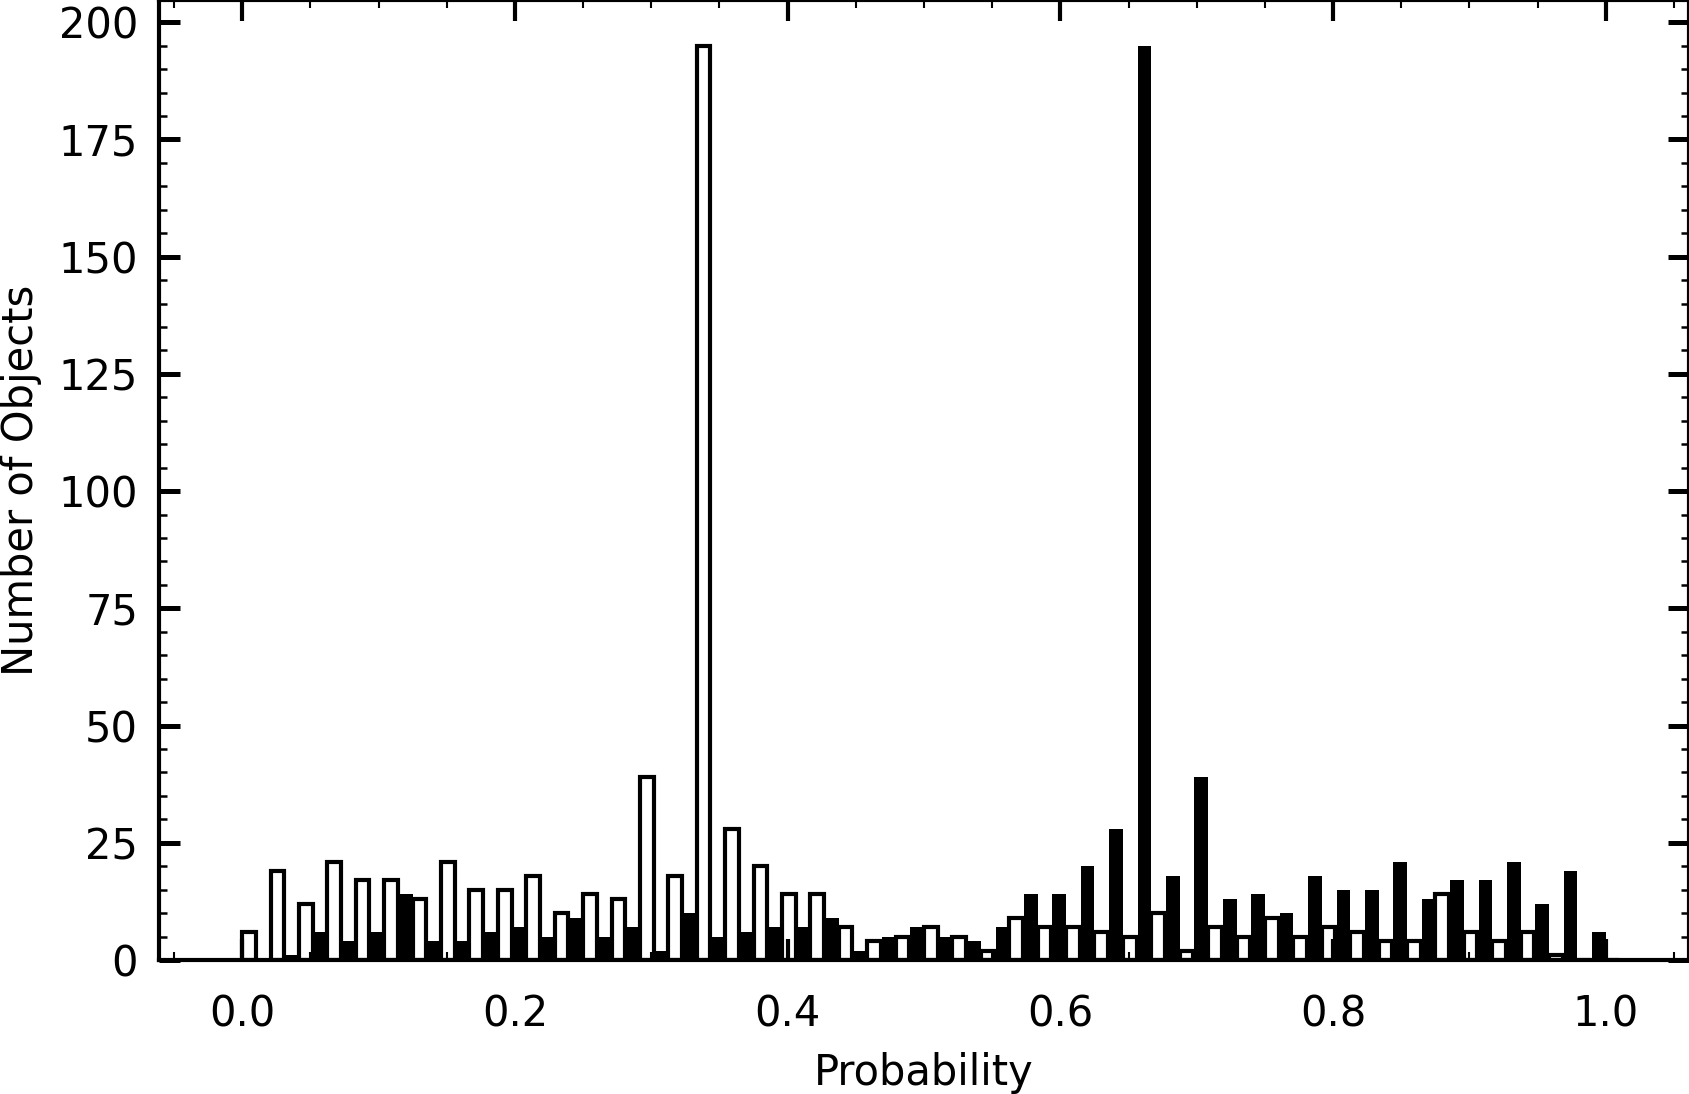

In [ ]:
import matplotlib.pyplot as plt
#print(y_proba)
probs = pd.DataFrame(y_proba,columns=('p_1','p_2'))
bin_probs_1 = pd.cut(probs['p_1'],np.linspace(0,1,50),include_lowest=True)
bin_probs_2 = pd.cut(probs['p_2'],np.linspace(0,1,50),include_lowest=True)

print(x_test.shape)

fig, ax = plt.subplots(figsize=(6,4),dpi=300)
x_axis = np.linspace(0,1,len(bin_probs_1.value_counts()))

ax.bar(x_axis-0.005,bin_probs_1.value_counts(sort=False), width=0.01,label='BLLs')
ax.bar(x_axis+0.005,bin_probs_2.value_counts(sort=False),width=0.01,label='FSRQs',color='white',edgecolor='black')
#ax.legend()
ax.set_xlabel('Probability')
ax.set_ylabel('Number of Objects')
ax.set_title('')

#plt.show()

In [ ]:
data = pd.read_csv(filepath, index_col=0)
data = data.dropna()
print(len(data))
X,Y = dp.choose_2_vars('CLASS1',data,1,2)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,random_state=randomstate)
correct = np.array([])
incorrect = np.array([])
y_actual = np.array(y_pred)

for i in range(0,len(y_pred)):
    if y_pred[i] == y_actual[i]:
        correct = np.append(correct,i)
    else:
        incorrect = np.append(incorrect, i)

inc_probs = np.array([])

for i in range(0,len(incorrect)):
    inc_probs = np.append(inc_probs, y_proba[0:int(incorrect[i])])

print(len(x_test))
print(len(y_test))


scaler = StandardScaler()  
rdgcount = 0
data_array = np.array(data) # all of x and y including radio galaxies
for i in range(0,len(data_array)):
    if data_array[i,0] == 3:  # if row number 'i' is a radio galaxy
        rdgcount +=1
        newrow = np.array(data_array[i])
        newrow = np.delete(newrow,0)
        x_test=np.append(x_test,[newrow],axis=0)   
        y_test = np.append(y_test,3)   


scaler.fit(x_train) 
x_test = scaler.transform(x_test)
y_pred = BNN.predict(x_test)
y_proba = BNN.predict_proba(x_test)


2363
693
693


In [ ]:
dataclassles = data.drop(columns='CLASS1')
df_test = pd.DataFrame(x_test,columns=[dataclassles.columns])
print(len(x_test))
print(len(y_pred))
df_test['CLASS1'] = y_test
df_test['y_pred'] = y_pred
df_test['y_probs_bll'] = y_proba.T[0]
df_test['y_probs_fsrq'] = y_proba.T[1]
df_test.to_csv('..\\Fermi-LAT Data\\ML_Results_withrdg.csv')
df_test.to_csv('..\\Search Area Results\\iteration_11_raw.csv')

693
693


"\nfor j in range(0,len(cols)):\n    for k in range(0,len(cols)):\n        if j > k:     \n            frac = np.array(data[cols[j]])\n            hr = np.array(data[cols[k]])\n            bllfrac=np.array([])\n            bllhr = np.array([])\n            fsrqfrac=np.array([])\n            fsrqhr = np.array([])\n            for i in range(0,len(y_pred)):\n                if y_pred[i] == 0:\n                    #print('bll')\n                    bllfrac=np.append(bllfrac,frac[i])\n                    bllhr=np.append(bllhr,hr[i])\n                if y_pred[i] == 1:\n                    #print('fsrq')\n                    fsrqfrac=np.append(fsrqfrac,frac[i])\n                    fsrqhr=np.append(fsrqhr,hr[i])\n\n            plt.scatter(fsrqfrac,fsrqhr,color='red')\n            plt.scatter(bllfrac,bllhr,color='blue')\n            plt.savefig('autoplot_' + cols[j] + '_and_' + cols[k] + '.png')\n            plt.clf()\n"

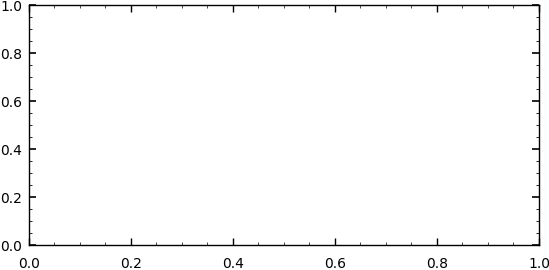

In [ ]:
data = pd.read_csv(filepath, index_col=0)
fig, ax = plt.subplots()
#plt.scatter(data['Frac_Variability'], data['HR_24'])
cols = data.columns
'''
for j in range(0,len(cols)):
    for k in range(0,len(cols)):
        if j > k:     
            frac = np.array(data[cols[j]])
            hr = np.array(data[cols[k]])
            bllfrac=np.array([])
            bllhr = np.array([])
            fsrqfrac=np.array([])
            fsrqhr = np.array([])
            for i in range(0,len(y_pred)):
                if y_pred[i] == 0:
                    #print('bll')
                    bllfrac=np.append(bllfrac,frac[i])
                    bllhr=np.append(bllhr,hr[i])
                if y_pred[i] == 1:
                    #print('fsrq')
                    fsrqfrac=np.append(fsrqfrac,frac[i])
                    fsrqhr=np.append(fsrqhr,hr[i])

            plt.scatter(fsrqfrac,fsrqhr,color='red')
            plt.scatter(bllfrac,bllhr,color='blue')
            plt.savefig('autoplot_' + cols[j] + '_and_' + cols[k] + '.png')
            plt.clf()
'''

In [ ]:
data = pd.read_csv('..\\Fermi-LAT Data\\fl_numericalonly_nopositional_withclasses.csv')


frac = np.array(data['Spectral_Index'])
hr = np.array(data['Flux1000'])
bllfrac=np.array([])
bllhr = np.array([])
fsrqfrac=np.array([])
fsrqhr = np.array([])
for i in range(0,len(y_pred)):
    if y_pred[i] == 0:
        #print('bll')
        bllfrac=np.append(bllfrac,frac[i])
        bllhr=np.append(bllhr,hr[i])
    if y_pred[i] == 1:
        #print('fsrq')
        fsrqfrac=np.append(fsrqfrac,frac[i])
        fsrqhr=np.append(fsrqhr,hr[i])

plt.scatter(fsrqfrac,fsrqhr,color='red')
plt.scatter(bllfrac,bllhr,color='blue')
plt.savefig('autoplot_' + cols[j] + '_and_' + cols[k] + '.png')
plt.clf()

KeyError: 'Spectral_Index'